# Обучение собсвенной сети по распознаванию лиц на основе RESNET как генератора вектора

Создадим датасет и разобьем на трейн и тест (часть людей на трейн и часть людей на тест при этом чтоб подмножества людей не пересекались)

In [193]:
import os
import random
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


class LFWFacesDataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None):
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        self.image_paths, self.labels = self._load_data()

    def _load_data(self):
        # Получаем список всех папок (имена людей)
        folders = sorted(os.listdir(self.root_dir))
        # Разделяем данные на тренировочный и валидационный наборы
        random.seed(42)
        random.shuffle(folders)
        split_index = int(0.75 * len(folders))
        if self.train:
            selected_folders = folders[:split_index]
            print("self.train:", self.train, len(selected_folders), selected_folders)
        else:
            selected_folders = folders[split_index:]
            print("self.train:", self.train, len(selected_folders), selected_folders)
        # Загружаем пути к изображениям и соответствующие им метки
        image_paths = []
        labels = []
        for i, folder in enumerate(selected_folders):
            folder_path = os.path.join(self.root_dir, folder)
            for filename in os.listdir(folder_path):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    image_paths.append(os.path.join(folder_path, filename))
                    labels.append(i)
        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Преобразования для тренировочных и валидационных данных
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Создаем объекты класса датасета для тренировочных и валидационных данных
train_dataset = LFWFacesDataset('LFW_faces_dataset_cropped', train=True, transform=train_transform)
val_dataset = LFWFacesDataset('LFW_faces_dataset_cropped', train=False, transform=val_transform)

self.train: True 42 ['Laura_Bush', 'Jean_Charest', 'Tariq_Aziz', 'Donald_Rumsfeld', 'German_Khan', 'Hans_Blix', 'Vicente_Fox', 'Xiang_Huaicheng', 'Naji_Sabri', 'Habib_Rizieq', 'Colin_Powell', 'Mark_Komara', 'Ranil_Wickremasinghe', 'Roy_Moore', 'John_Bond', 'Yasser_Arafat', 'Ariel_Sharon', 'Hugo_Chavez', 'Silvio_Berlusconi', 'Arnold_Schwarzenegger', 'John_Ashcroft', 'Deb_Santos', 'Recep_Tayyip_Erdogan', 'Igor_Ivanov', 'Paul_McNulty', 'Jeff_Hornacek', 'Abdullah_Gul', 'Jesse_Jackson', 'Sureyya_Ayhan', 'Gray_Davis', 'Lee_Baca', 'Nestor_Kirchner', 'Jimmy_Iovine', 'Dragan_Covic', 'Phil_Mickelson', 'Luiz_Inacio_Lula_da_Silva', 'Taha_Yassin_Ramadan', 'Emily_Stevens', 'Salma_Hayek', 'Wang_Hailan', 'Alvaro_Uribe', 'Joanne_Woodward']
self.train: False 14 ['Nicanor_Duarte_Frutos', 'Ben_Chandler', 'Mary-Kate_Olsen', 'Reginald_Hudlin', 'Bob_Newhart', 'Vladimir_Putin', 'Claudia_Pechstein', 'George_W_Bush', 'Gerhard_Schroeder', 'Gerry_Kelly', 'Stefano_Gabbana', 'Alejandro_Toledo', 'Choi_Sung-hong', 'R

---

Даталоадер, формирующий каждый раз триплет:

In [195]:
import torch
from torch.utils.data import Dataset, DataLoader

class TripletDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.class_indices = {}
        for idx, label in enumerate(dataset.labels):
            if label not in self.class_indices:
                self.class_indices[label] = []
            self.class_indices[label].append(idx)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        anchor_label = self.dataset.labels[idx]

        # Select positive sample from the same class
        samples = self.class_indices[anchor_label]
        positive_idx, anchor_idx = random.sample(samples,2)

        positive_img = self.dataset[positive_idx][0]
        anchor_img = self.dataset[anchor_idx][0]

        # Select negative sample from a different class
        negative_label = random.choice([label for label in self.class_indices.keys() if label != anchor_label])
        negative_idx = random.choice(self.class_indices[negative_label])
        negative_img = self.dataset[negative_idx][0]

        return anchor_img, positive_img, negative_img


train_triplet_dataset = TripletDataset(train_dataset)
val_triplet_dataset = TripletDataset(val_dataset)

train_loader = DataLoader(train_triplet_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_triplet_dataset, batch_size=64, shuffle=False)


Пример с трейнового набора:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


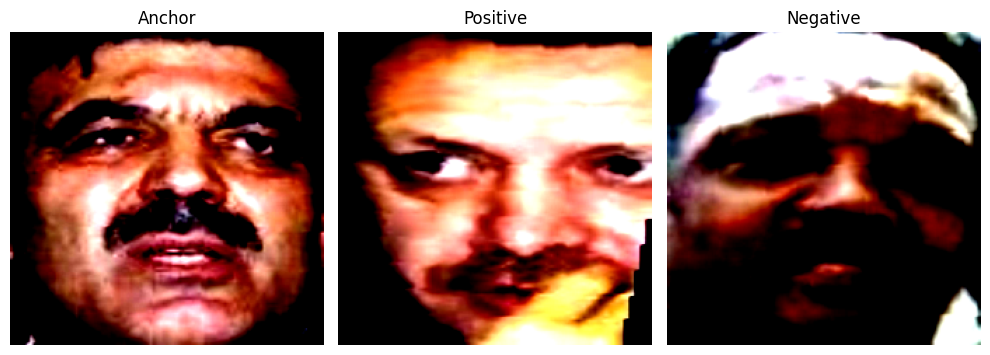

In [196]:
# Генерируем один триплет
anchors, positives, negatives = next(iter(train_loader))

# Визуализируем триплет в subplot
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Преобразуем тензоры обратно в NumPy массивы для визуализации
anchors_np = anchors.permute(0, 2, 3, 1).numpy()
positives_np = positives.permute(0, 2, 3, 1).numpy()
negatives_np = negatives.permute(0, 2, 3, 1).numpy()

# Визуализируем три изображения
axs[0].imshow(anchors_np[0])
axs[0].set_title('Anchor')
axs[1].imshow(positives_np[0])
axs[1].set_title('Positive')
axs[2].imshow(negatives_np[0])
axs[2].set_title('Negative')

# Удаляем оси для всех изображений
for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

Пример с валидационного набора:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


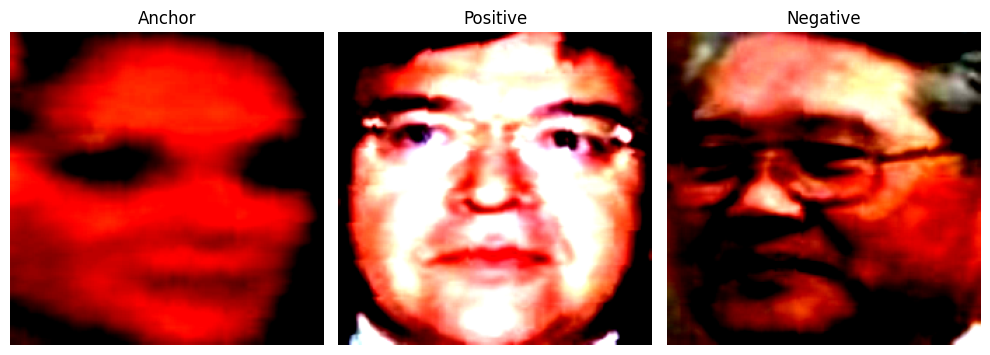

In [197]:
# Генерируем один триплет
anchors, positives, negatives = next(iter(val_loader))

# Визуализируем триплет в subplot
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Преобразуем тензоры обратно в NumPy массивы для визуализации
anchors_np = anchors.permute(0, 2, 3, 1).numpy()
positives_np = positives.permute(0, 2, 3, 1).numpy()
negatives_np = negatives.permute(0, 2, 3, 1).numpy()

# Визуализируем три изображения
axs[0].imshow(anchors_np[0])
axs[0].set_title('Anchor')
axs[1].imshow(positives_np[0])
axs[1].set_title('Positive')
axs[2].imshow(negatives_np[0])
axs[2].set_title('Negative')

# Удаляем оси для всех изображений
for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

Лосс функция:

In [199]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [201]:
# Определение функции для обучения одной эпохи
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for batch_idx, (anchors, positives, negatives) in tqdm(enumerate(train_loader)):
        anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
        optimizer.zero_grad()
        anchor_embeddings = model(anchors).squeeze(2,3)
        positive_embeddings = model(positives).squeeze(2,3)
        negative_embeddings = model(negatives).squeeze(2,3)
        loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #print(loss.item())
        #torch.cuda.empty_cache()
    avg_loss = running_loss / len(train_loader)
    print(f'Train Epoch: \tLoss: {avg_loss:.6f}')
    return avg_loss

# Определение функции для оценки потерь на валидационном наборе
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_idx, (anchors, positives, negatives) in tqdm(enumerate(val_loader)):
            anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
            anchor_embeddings = model(anchors).squeeze(2,3)
            positive_embeddings = model(positives).squeeze(2,3)
            negative_embeddings = model(negatives).squeeze(2,3)
            loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
            running_loss += loss.item()
            #torch.cuda.empty_cache()
            #print(loss.item())
    avg_loss = running_loss / len(val_loader)
    print(f'Val Epoch: \tLoss: {avg_loss:.6f}')
    return avg_loss

Создание архитектуры:

In [202]:
import torch
from torchvision.models import resnet18

# Перемещаем модель на GPU, если она доступна
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Загрузите предварительно обученную модель ResNet-18
model = resnet18(weights='DEFAULT')
model = model.to(device).train()

# Извлеките слой "avgpool" для получения фичей перед полносвязанным слоем
model = torch.nn.Sequential(*list(model.children())[:-1])

# Пример инференса батча и получение 512 числе как вектор изображения
model(anchors.to(device)).squeeze(2,3).shape

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/anton/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 10.7MB/s]


torch.Size([63, 512])

In [203]:
criterion = TripletLoss()

# Оптимизатор
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [205]:
criterion(model(anchors.to(device).squeeze(2,3)), model(positives.to(device).squeeze(2,3)), model(negatives.to(device).squeeze(2,3)))

tensor(27.9265, grad_fn=<MeanBackward0>)

Обучение сети:

Val Epoch before training:


0it [00:00, ?it/s]

1it [00:08,  8.33s/it]


Val Epoch: 	Loss: 22.202477
----------------
Epoch 1/10 training:


2it [00:43, 21.68s/it]


Train Epoch: 	Loss: 40.906035


1it [00:08,  8.85s/it]


Val Epoch: 	Loss: 1112.581421
----------------
Epoch 2/10 training:


2it [00:47, 23.65s/it]


Train Epoch: 	Loss: 39.980853


1it [00:07,  7.36s/it]


Val Epoch: 	Loss: 324638.156250
----------------
Epoch 3/10 training:


2it [00:48, 24.02s/it]


Train Epoch: 	Loss: 40.666111


1it [00:07,  7.62s/it]


Val Epoch: 	Loss: 99594.351562
----------------
Epoch 4/10 training:


2it [00:42, 21.42s/it]


Train Epoch: 	Loss: 16.386914


1it [00:07,  7.46s/it]


Val Epoch: 	Loss: 1225.721802
----------------
Epoch 5/10 training:


2it [00:41, 20.89s/it]


Train Epoch: 	Loss: 6.328323


1it [00:07,  7.68s/it]


Val Epoch: 	Loss: 185.460220
----------------
Epoch 6/10 training:


2it [00:49, 24.63s/it]


Train Epoch: 	Loss: 4.574650


1it [00:07,  7.31s/it]


Val Epoch: 	Loss: 36.408115
----------------
Epoch 7/10 training:


2it [00:43, 21.51s/it]


Train Epoch: 	Loss: 2.989808


1it [00:07,  7.63s/it]


Val Epoch: 	Loss: 19.266088
----------------
Epoch 8/10 training:


2it [00:44, 22.13s/it]


Train Epoch: 	Loss: 3.668762


1it [00:07,  7.99s/it]


Val Epoch: 	Loss: 6.909888
----------------
Epoch 9/10 training:


2it [00:46, 23.12s/it]


Train Epoch: 	Loss: 1.096678


1it [00:08,  8.76s/it]


Val Epoch: 	Loss: 5.107526
----------------
Epoch 10/10 training:


2it [00:44, 22.38s/it]


Train Epoch: 	Loss: 2.119195


1it [00:07,  7.35s/it]


Val Epoch: 	Loss: 1.700207


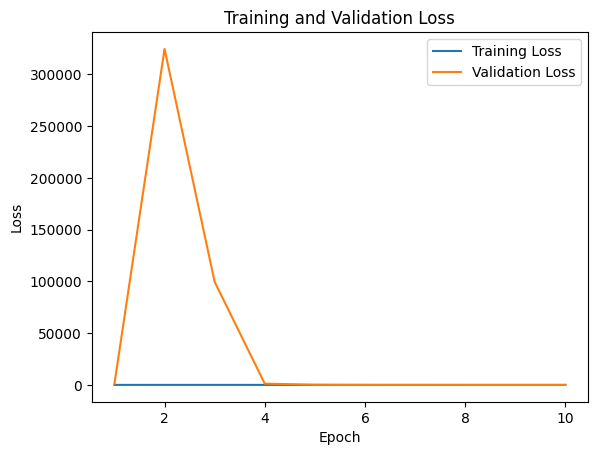

In [206]:
# Оценка потерь на валидационном наборе до начала обучения
print("Val Epoch before training:")
validate_epoch(model, val_loader, criterion, device)

# Обучение модели на протяжении нескольких эпох
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    print("----------------")
    print(f"Epoch {epoch+1}/{num_epochs} training:")
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = validate_epoch(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Построение графиков
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [11]:
criterion(model(anchors.to(device)), model(positives.to(device)), model(negatives.to(device)))

tensor(0.3698, device='cuda:0', grad_fn=<MeanBackward0>)

Сохранение итога:

In [13]:
model.eval()
# Сохранение весов модели в формате .pth
torch.save(model.state_dict(), 'model_weights.pth')


# Создаем скриптовую версию модели
scripted_model = torch.jit.script(model)

# Сохраняем скриптовую версию модели в формате .pt
scripted_model.save('model_scripted.pt')